# RNN for the original whole dataset

In [1]:
# Import of required libraries and functions from 'make_dataset' script
import os
from make_dataset import Discotope_Dataset
import numpy as np
import torch
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, roc_auc_score
from tqdm import tqdm
from IPython.display import clear_output

C:\Users\minij\anaconda3\envs\special_course\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import tensorflow and keras
import tensorflow as tf
from tensorflow import keras

In [3]:
tf.random.set_seed(1234)

In [4]:
def data_load(name_set, data_dir, separate=False):
    
    '''
    Function to load training, validation or test data from the folder/directory you have storaged the whole dataset
        - 'name_set': text variable with the type of data set to load ('train', 'test', 'valid')
        - 'data_dir': directory where you have storaged the data set (in my case is '../Data/')
        - 'separate': boolean that returns the PDBs and AF2 sets separately (only when True)
    
    Output:
        - 'X_all': all observations from both solved and predicted structures all together
        - 'y_all': all labels from both solved and predicted structures all together
        - 'N_solved': number of observations from solved structures (in case of wanted to unmerge the 'all' array)
        - 'N_af2': number of observations from predicted structures (in case of wanted to unmerge the 'all' array)
    '''
    
    # 'Pathlib module' load to work with windows path
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    
    # List of all subdirectories inside the data directory
    dirs = [d for d in os.listdir(data_dir)]
    
    # 're' module to use regex for filtering the specific directories according to the type of data set to load
    pattern = '.*' + name_set + '.*'
    R = re.compile(pattern)
    filtered = [folder for folder in dirs if R.match(folder)]
    
    # Loading the data set for solved structures and AlphaFold2 predicted structures
    path_af2 = data_dir + filtered[0] + '/dataset.pt'
    path_solved = data_dir + filtered[1] + '/dataset.pt'
    set_af2 = torch.load(path_af2)
    set_solved = torch.load(path_solved)
    
    # Stack all features and targets to one big array (removing NaN entries)
    X_set_solved = np.concatenate([set_solved[i]["X_arr"] for i in range(0, len(set_solved), 1) if not set_solved[i]['df_stats']['rsa'].isna().any()])
    y_set_solved = np.concatenate([set_solved[i]["y_arr"] for i in range(0, len(set_solved), 1) if not set_solved[i]['df_stats']['rsa'].isna().any()])
    X_set_af2 = np.concatenate([set_af2[i]["X_arr"] for i in range(0, len(set_solved), 1) if not set_solved[i]['df_stats']['rsa'].isna().any()])
    y_set_af2 = np.concatenate([set_af2[i]["y_arr"] for i in range(0, len(set_solved), 1) if not set_solved[i]['df_stats']['rsa'].isna().any()])
    
    # Nº of observations for each subtype of data set
    N_set_solved = X_set_solved.shape[0]
    N_set_af2 = X_set_af2.shape[0]
    
    # Stack all features and targets from solved and predicted structures into only one big
    X_set_all = np.concatenate((X_set_solved, X_set_af2), axis=0)
    y_set_all = np.concatenate((y_set_solved, y_set_af2), axis=0)
    
    if (separate==True):
        return(X_set_all, y_set_all, X_set_solved, y_set_solved, X_set_af2, y_set_af2)
    else:
        return(X_set_all, y_set_all, N_set_solved, N_set_af2)

In [5]:
def results_df_stats_creation(name_set, data_dir):
    
    '''
    Function to store the stats information from each pdb of the original dataset
        - 'name_set': text variable with the type of data set to load ('train', 'test', 'valid')
        - 'data_dir': directory where you have storaged the data set (in my case is '../Data/')
    
    Output:
        - 'stats_df_solved': dataframe for the solved structures (removing NaN entries of RSA values)
        - 'stats_df_af2': dataframe for the AF2 structures (removing NaN entries of RSA values)
    '''
    
    # 'Pathlib module' load to work with windows path
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    
    # List of all subdirectories inside the data directory
    dirs = [d for d in os.listdir(data_dir)]
    
    # 're' module to use regex for filtering the specific directories according to the type of data set to load
    pattern = '.*' + name_set + '.*'
    R = re.compile(pattern)
    filtered = [folder for folder in dirs if R.match(folder)]
    
    # Loading the data set for solved structures and AlphaFold2 predicted structures
    path_af2 = data_dir + filtered[0] + '/dataset.pt'
    path_solved = data_dir + filtered[1] + '/dataset.pt'
    set_af2 = torch.load(path_af2)
    set_solved = torch.load(path_solved)
    
    # Stats dataframe creation for SOLVED and AF2 structures (removing 'NaN' entries according the PDB set)
    stats_dfs_solved = []
    stats_dfs_af2 = []
    for i in range(0, len(set_solved), 1):
        sample = set_solved[i]
        sample_af2 = set_af2[i]
        df_sample = sample['df_stats']
        df_sample_af2 = sample_af2['df_stats']
        
        # Removing 'NaN' entries and adding the epitope column
        if(df_sample['rsa'].isna().any() == False):
            df_sample['epitope'] = sample['y_arr'].astype(bool)
            df_sample_af2['epitope'] = sample_af2['y_arr'].astype(bool)
            stats_dfs_solved.append(df_sample)
            stats_dfs_af2.append(df_sample_af2)
    
    return(stats_dfs_solved, stats_dfs_af2)

In [6]:
def dataframe_load(name_set, data_dir):
    
    '''
    Function to load training, validation or test dataframes from the folder/directory you have storaged the whole dataset.
    This function is specifically to have the original dataframes of the data, and their corresponding description
        - 'name_set': text variable with the type of data set to load ('train', 'test', 'valid')
        - 'data_dir': directory where you have storaged the data set (in my case is '../Data/')
    
    Output:
        - 'set_af2': dataframe for AF2 predicted structures
        - 'set_solved': dataframe for PDB solved structures
    '''
    
    # 'Pathlib module' load to work with windows path
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    
    # List of all subdirectories inside the data directory
    dirs = [d for d in os.listdir(data_dir)]
    
    # 're' module to use regex for filtering the specific directories according to the type of data set to load
    pattern = '.*' + name_set + '.*'
    R = re.compile(pattern)
    filtered = [folder for folder in dirs if R.match(folder)]
    
    # Loading the data set for solved structures and AlphaFold2 predicted structures
    path_af2 = data_dir + filtered[0] + '/dataset.pt'
    path_solved = data_dir + filtered[1] + '/dataset.pt'
    set_af2 = torch.load(path_af2)
    set_solved = torch.load(path_solved)
    
    return(set_af2, set_solved)

In [7]:
def remove_NaN(data, y):
    
    '''
    Function to remove NaN values (some PDB entries have RSA NaN values)
        - 'data': numpy array with the specific (train, valid, test) data
        - 'y': numpy array with the specific (train, valid, test) labels
    
    Output:
        - 'data_noNaN': array withouth the entries/observations that contain NaN values
    '''
    
    # Merging X and y arrays all together
    joint_data = np.hstack((data, y.reshape(-1, 1)))
    
    # Removal of NaN entries
    nan_rows = np.isnan(joint_data).any(axis=1)
    data_noNaN = joint_data[~nan_rows, :]
    
    # Demerging the final array into X and y
    X_noNaN = data_noNaN[:, 0:data.shape[1]]
    y_noNaN = data_noNaN[:,-1]
    
    return(X_noNaN, y_noNaN)

In [8]:
def normalize_train(X):
    
    '''
    Function to normalize the columns 532 (pLLDT) and 533 (length) because they have high length
        - 'X': data to normalize
    '''
    
    # Create a copy of the X vector to do the normalization
    X_scaled = X.copy()
    
    # Create an instance of MinMaxScaler
    scaler = StandardScaler()
    
    # Fit the scaler to the data 
    #scaler.fit(X_scaled[:, 532:534])
    scaler.fit(X_scaled)
    
    # Transform the data
    #X_scaled[:, 532:534] = scaler.fit_transform(X_scaled[:, 532:534])
    X_scaled = scaler.fit_transform(X_scaled)
    return(X_scaled)

In [9]:
def Z_transform_train(X, cols_to_select):
    
    '''
    Function to normalize the columns 532 (pLLDT) and 533 (length) because they have high length
        - 'X': data to normalize
    '''
    
    # Obtain the mean and standard deviation for each feature on the array
    X_mean = np.mean(X[:, cols_to_select], axis=0)
    X_std = np.std(X[:, cols_to_select], axis=0)
    
    # Correcting pLDDT column sd in case of using only PDB set
    X_std[X_std == 0] = 1
    
    # Z-transform (standardization)
    X[:, cols_to_select] = (X[:, cols_to_select] - X_mean)/X_std
    return(X, X_mean, X_std)

In [10]:
def Z_transform_valid(X, mean_train, sd_train, cols_to_select):
    
    '''
    Function to normalize the columns 532 (pLLDT) and 533 (length) because they have high length
        - 'X': data to normalize
        - 'mean_train': mean from standardized training set
        - 'sd_train': standard deviation from standardized training set
    '''
    
    # Z-transform (standardization)
    X[:, cols_to_select] = (X[:, cols_to_select] - mean_train)/sd_train
    return(X)

In [11]:
def class_weight_calculator(y_train):
        
    '''
    Function to calculate the class weights for the unbalanced data
        - 'y_train': training labels (contains 0 and 1)
    '''
    
    # Compute the class weights with sklearn function
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

    # Convert the class weights to a dictionary
    class_weight = dict(enumerate(class_weights))
    return(class_weight)

In [12]:
# Neuronal network model with one layer and one hidden unit
def nn1_model(train_data, y_train, act_fun, loss_fun, alpha, class_weight_fn, batch = None, balancing=True):
    
    '''
    Function to create and train/validate the feed-forward neuronal network with only 1 hidden layer
        -'train_data': X train standardized
        -'y_train': training labels
        -'act_fun': activation function
        -'loss_fun': loss function
        -'class_weight_calculator': function to calculate the weights for each class
        -'batch': batch_size (baseline is None, but can be changed by adding a integer as new value)
        -'balancing': True/False argument for incorporating balancing in classes
    
    Output:
        -'model': neural network model trained
        -'history': attributes obtained during fitting the model
    '''
    
    # Calculation of the class weights with function previously defined
    class_weight = class_weight_fn(y_train)
    
    # Normalization of the class_weight to sum 1
    tot = class_weight[0] + class_weight[1]
    class_weight[0] = class_weight[0]/tot
    class_weight[1] = class_weight[1]/tot
    
    # Implementation of keras for creating a sequential model with 1 layer
    tf.random.set_seed(1234)
    from keras.layers import Dense, Dropout
    from keras import regularizers, metrics
    
    model = keras.Sequential()
    # Input layer with train_data.shape neurons and a hidden layer with 1 neuron
    model.add(Dense(1, activation=act_fun, input_shape=train_data.shape[1:], kernel_regularizer=regularizers.l2(alpha)))
    # Output layer with sigmoid activation (better for binary classification)
    model.add(Dense(1, activation='sigmoid'))
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss=loss_fun, metrics=
                  ['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC(), loss_fun])
    
    if (balancing == True):
        history = model.fit(train_data, y_train, epochs = 100, batch_size=batch, verbose=0, class_weight=class_weight)
    else:
        history = model.fit(train_data, y_train, epochs = 100, batch_size=batch, verbose=0)
    
    return(model, history)

In [13]:
# Neuronal network model with one layer and 10 hidden unit
def nn10_model(train_data, y_train, act_fun, loss_fun, alpha, class_weight_fn, drop_rate, batch = None, balancing=True):
    
    '''
    Function to create and train/validate the feed-forward neuronal network with only 1 hidden layer
        -'train_data': X train standardized
        -'y_train': training labels
        -'act_fun': activation function
        -'loss_fun': loss function
        -'class_weight_calculator': function to calculate the weights for each class
        -'batch': batch_size (baseline is None, but can be changed by adding a integer as new value)
        -'balancing': True/False argument for incorporating balancing in classes
    
    Output:
        -'model': neural network model trained
        -'history': attributes obtained during fitting the model
    '''
    
    # Calculation of the class weights with function previously defined
    class_weight = class_weight_fn(y_train)
    
    # Normalization of the class_weight to sum 1
    tot = class_weight[0] + class_weight[1]
    class_weight[0] = class_weight[0]/tot
    class_weight[1] = class_weight[1]/tot
    
    # Implementation of keras for creating a sequential model with 1 layer
    tf.random.set_seed(1234)
    from keras.layers import Dense, Dropout
    from keras import regularizers, metrics
    
    model = keras.Sequential()
    # Input layer with train_data.shape neurons and a hidden layer with 1 neuron
    model.add(Dense(10, activation=act_fun, input_shape=train_data.shape[1:], kernel_regularizer=regularizers.l2(alpha)))
    model.add(Dropout(drop_rate))
    # Output layer with sigmoid activation (better for binary classification)
    model.add(Dense(1, activation='sigmoid'))
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss=loss_fun, metrics=
                  ['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC(), loss_fun])
    
    if (balancing == True):
        history = model.fit(train_data, y_train, epochs = 100, batch_size=batch, verbose=0, class_weight=class_weight)
    else:
        history = model.fit(train_data, y_train, epochs = 100, batch_size=batch, verbose=0)
    
    return(model, history)

In [14]:
def loss_plot(loss_values):
    
    '''
    Function to plot the loss curve of the training of the model
        - 'loss_values': array with the loss values for each iteration of the training
    '''
    
    plt.plot(loss_values, label = 'Train')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

In [15]:
def ROC_AUC(y_true, y_hat):
    
    '''
    Function to obtain the AUC value based on the ROC curve
        - 'y_true': y original values
        - 'y_hat': y predicted values
        
    Output:
        - 'ROC_auc': AUC value
    '''
    
    fpr, tpr, _ = metrics.roc_curve(y_true, y_hat)
    ROC_auc = metrics.auc(fpr, tpr)
    return(ROC_auc)

In [16]:
def PR_AUC(y_true, y_hat):
    
    '''
    Function to obtain the AUC value based on the precision and recall parameters
        - 'y_true': y original values
        - 'y_hat': y predicted values
        
    Output:
        - 'PR_auc': AUC value
    '''
    
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_hat)
    PR_auc = metrics.auc(recall, precision)
    return(PR_auc)

In [17]:
# Epitope rank percentile score
# https://github.com/Magnushhoie/discotope3/blob/main/src/models/mlscripts.py#L55

def get_percentile_score_arr(
    scores: np.array,
    epitopes: np.array,
):
    
    """Find mean predicted epitope rank percentile score from the scores (y_hat) and the epitopes (y_true)"""
    epitopes_bool = epitopes.astype(bool)
    assert epitopes_bool.dtype == "bool"

    c = scores[epitopes_bool].mean()
    c_percentile = (c > scores).mean()

    return c_percentile

In [18]:
# Data loading for training, validation, and test data sets (needs a couple of minutes)
X_train, y_train, X_train_PDB, y_train_PDB, X_train_af2, y_train_af2 = data_load(name_set='train', data_dir='../Data/', separate = True)
X_valid, y_valid, X_valid_PDB, y_valid_PDB, X_valid_af2, y_valid_af2 = data_load(name_set='valid', data_dir='../Data/', separate = True)
X_test, y_test, X_test_PDB, y_test_PDB, X_test_af2, y_test_af2 = data_load(name_set='test', data_dir='../Data/', separate = True)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((446835, 536), (446835,), (115978, 536), (115978,), (11882, 536), (11882,))

In [19]:
## NOT NEEDED: ALREADY REMOVED WHEN LOADING THE DATA
# Data manipulation to remove all PDB entries with NaN values in the RSA feature (535)

# X_train, y_train = remove_NaN(data=X_train, y=y_train)
# X_valid, y_valid = remove_NaN(data=X_valid, y=y_valid)
# X_test, y_test = remove_NaN(data=X_test, y=y_test)

# X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

In [20]:
# Data normalization
cols = list(range(0, 512)) + [532] + [533] + [535]
X_train_sc, mean_X_train, sd_X_train = Z_transform_train(X_train, cols_to_select=cols)
X_valid_sc = Z_transform_valid(X_valid, mean_X_train, sd_X_train, cols_to_select=cols)
X_test_sc = Z_transform_valid(X_test, mean_X_train, sd_X_train, cols_to_select=cols)

X_train_sc.shape, X_valid_sc.shape, X_test_sc.shape

((446835, 536), (115978, 536), (11882, 536))

In [21]:
# Data normalization (PDB only)
cols = list(range(0, 512)) + [532] + [533] + [535]
X_train_PDB_sc, mean_X_train_PDB, sd_X_train_PDB = Z_transform_train(X_train_PDB, cols_to_select=cols)
X_valid_PDB_sc = Z_transform_valid(X_valid_PDB, mean_X_train_PDB, sd_X_train_PDB, cols_to_select=cols)
X_test_PDB_sc = Z_transform_valid(X_test_PDB, mean_X_train_PDB, sd_X_train_PDB, cols_to_select=cols)

X_train_PDB_sc.shape, X_valid_PDB_sc.shape, X_test_PDB_sc.shape

((223346, 536), (57989, 536), (5941, 536))

In [22]:
# Data normalization (AF2 only)
cols = list(range(0, 512)) + [532] + [533] + [535]
X_train_af2_sc, mean_X_train_af2, sd_X_train_af2 = Z_transform_train(X_train_af2, cols_to_select=cols)
X_valid_af2_sc = Z_transform_valid(X_valid_af2, mean_X_train_af2, sd_X_train_af2, cols_to_select=cols)
X_test_af2_sc = Z_transform_valid(X_test_af2, mean_X_train_af2, sd_X_train_af2, cols_to_select=cols)

X_train_af2_sc.shape, X_valid_af2_sc.shape, X_test_af2_sc.shape

((223489, 536), (57989, 536), (5941, 536))

In [23]:
# Class unbalanced in train
zero, one = np.bincount(y_train.astype(int))
total = zero + one
print("Class count (train):\n\n      Total: {}\n      Epitope label: {} ({:.2f}% of total)".format(total, one, 100*one/total))

Class count (train):

      Total: 446835
      Epitope label: 40938 (9.16% of total)


In [24]:
# Class unbalanced in valid
zero, one = np.bincount(y_valid.astype(int))
total = zero + one
print("Class count (validation):\n\n      Total: {}\n      Epitope label: {} ({:.2f}% of total)".format(total, one, 100*one/total))

Class count (validation):

      Total: 115978
      Epitope label: 9578 (8.26% of total)


In [25]:
# Class unbalanced in train
zero, one = np.bincount(y_test.astype(int))
total = zero + one
print("Class count (test):\n\n      Total: {}\n      Epitope label: {} ({:.2f}% of total)".format(total, one, 100*one/total))

Class count (test):

      Total: 11882
      Epitope label: 712 (5.99% of total)


In [26]:
# Calculation of the class weights with function previously defined
class_weight = class_weight_calculator(y_train)
    
# Normalization of the class_weight to sum 1
tot = class_weight[0] + class_weight[1]
class_weight[0] = class_weight[0]/tot
class_weight[1] = class_weight[1]/tot
    
print("Class weight implemented")
class_weight

Class weight implemented


{0: 0.09161771123569103, 1: 0.9083822887643089}

## Results dataframes for each PDB in the validation (comparison with DiscoTope results) 

In [27]:
# Loading stats dataframe for comparison with DISCOTOPE results
stats_test_solved, stats_test_AF2 = results_df_stats_creation(name_set='test', data_dir='../Data/')

len(stats_test_solved), len(stats_test_AF2)

(21, 21)

In [28]:
# Checking that the sum of the length of each PDB ID is equal to the y_valid array
# And creating a dictionary with the PDB_id and the protein length

PDB_id = []
length_PDB = np.empty(len(stats_test_solved))
tot_len = 0
for i in range(0, len(stats_test_solved), 1):
    
    # Sum of all the lengths
    sample = stats_test_solved[i]
    tot_len = tot_len + sample['length'][0]
    
    # Storing PDB and length
    PDB_id.append(sample['pdb'][0][0:6])
    length_PDB[i] = sample['length'][0]

# Creating the dictionary of PDB -> Length
PDB_length_dict = dict(zip(PDB_id, length_PDB))

print('Nº of proteins in the test set:', len(PDB_id))
print('\nAre the total length equal to the y_test?', tot_len == len(y_test_PDB))

Nº of proteins in the test set: 21

Are the total length equal to the y_test? True


## Training with whole data set (1 hidden unit structure)

In [29]:
# Parameters definition
loss = 'binary_crossentropy'
act = 'relu'
l2_value = 0.0001
batch_size = 128
class_balancing = False

In [30]:
# Training and validation of the model
model, history = nn1_model(train_data=X_train_sc, y_train=y_train, act_fun=act, loss_fun=loss, alpha=l2_value, 
                          class_weight_fn=class_weight_calculator, batch = batch_size, balancing = class_balancing)    

# Obtaining probabilities values for whole test, test_PDB, and test_AF2
y_pred_test_prob = model.predict(X_test_sc)
y_pred_test_PDB_prob = model.predict(X_test_PDB_sc)
y_pred_test_af2_prob = model.predict(X_test_af2_sc)

186/186 [==============================] - 0s 1ms/step


In [31]:
# Mean of the y_pred_valid_prob
y_pred_test_prob_mean = np.empty(len(y_pred_test_PDB_prob))
for i in range(0, len(y_pred_test_PDB_prob), 1):
    y_pred_test_prob_mean[i] = (y_pred_test_prob[i] + y_pred_test_prob[len(y_pred_test_PDB_prob)+i])/2

In [32]:
# Loop to calculate the AUC for each PDB id (protein)

k = 0
cont = 0
AUC_id_total = np.empty(len(PDB_id))
AUC_id_solved = np.empty(len(PDB_id))
AUC_id_af2 = np.empty(len(PDB_id))

for i in PDB_id:
    
    # Predicted values for a protein
    y_pred_id = np.concatenate((y_pred_test_prob[cont:(cont+int(PDB_length_dict[i]))], 
                               y_pred_test_prob[(cont+len(y_test_PDB)):(cont+len(y_test_PDB)+int(PDB_length_dict[i]))]))
    y_pred_id_solved = y_pred_test_PDB_prob[cont:(cont+int(PDB_length_dict[i]))]
    y_pred_id_af2 = y_pred_test_af2_prob[cont:(cont+int(PDB_length_dict[i]))]
    
    # Real values for a protein
    y_test_id = np.concatenate((y_test[cont:(cont+int(PDB_length_dict[i]))], 
                               y_test[(cont+len(y_test_PDB)):(cont+len(y_test_PDB)+int(PDB_length_dict[i]))]))
    y_test_id_solved = y_test_PDB[cont:(cont+int(PDB_length_dict[i]))]
    y_test_id_af2 = y_test_af2[cont:(cont+int(PDB_length_dict[i]))]
    
    # AUC value for each protein
    AUC_id_total[k] = ROC_AUC(y_test_id, y_pred_id)
    AUC_id_solved[k] = ROC_AUC(y_test_id_solved, y_pred_id_solved)
    AUC_id_af2[k] = ROC_AUC(y_test_id_af2, y_pred_id_af2)
    
    k += 1
    cont = cont + int(PDB_length_dict[i])

In [33]:
# AUC scores for each type of test set
AUC_id_total, AUC_id_solved, AUC_id_af2

(array([0.68772379, 0.5706278 , 0.5528607 , 0.87749446, 0.87245042,
        0.90519312, 0.43125   , 0.83327755, 0.51557445, 0.83888712,
        0.75688428, 0.68745308, 0.72955865, 0.66231405, 0.6906922 ,
        0.90156062, 0.625     , 0.87821948, 0.39772727, 0.68877969,
        0.60665509]),
 array([0.68797954, 0.7309417 , 0.57155399, 0.90022173, 0.8759915 ,
        0.91014609, 0.4375    , 0.78482972, 0.56678066, 0.84757653,
        0.76299505, 0.69078453, 0.7387921 , 0.63272727, 0.66364247,
        0.91489929, 0.68512974, 0.85274356, 0.29545455, 0.64946765,
        0.60787037]),
 array([0.6859335 , 0.44394619, 0.54155692, 0.84700665, 0.86798867,
        0.90174104, 0.4375    , 0.89427663, 0.46556983, 0.828125  ,
        0.75061881, 0.68796922, 0.71962834, 0.70975207, 0.73790323,
        0.87981859, 0.57235529, 0.90201568, 0.5       , 0.72235872,
        0.62361111]))

In [34]:
# Dataframe with the AUC results of each protein (PDB ID)

import warnings
warnings.filterwarnings('ignore')

# Create an empty DataFrame with the required columns
df_results = pd.DataFrame(columns=['PDB_ID', 'Length', 'AUC_total (1hu)', 'AUC_af2 (1hu)', 'AUC_DT_af2', 
                                   'AUC_solved (1hu)', 'AUC_DT_solved'])

cont = 0
for i in range(0, len(stats_test_solved), 1):
    
    # Loading results dataframe and important variables
    sample = stats_test_solved[i]
    pdb_id = sample['pdb'][0][0:6]
    length_pdb = sample['length'][0]
    
    # Calculate the AUC value for each protain according from the DiscoTope model (AF2)
    df_discotope = pd.read_csv('discotope3_testset_benchmark.csv')
    y_pred_af2_discotope = df_discotope.loc[df_discotope['pdb'] == pdb_id, 'DT3_af2']
    y_test_id_af2 = y_test_af2[cont:(cont+int(length_pdb))]
    AUC_af2_discotope = ROC_AUC(y_test_id_af2, y_pred_af2_discotope)
    
    # Calculate the AUC value for each protain according from the DiscoTope model (solved)
    y_pred_solved_discotope = df_discotope.loc[df_discotope['pdb'] == pdb_id, 'DT3_solved']
    y_test_id_solved = y_test_PDB[cont:(cont+int(length_pdb))]
    AUC_solved_discotope = ROC_AUC(y_test_id_solved, y_pred_solved_discotope)
    
    # Create a new row with the specific values
    new_row = pd.DataFrame([[pdb_id, length_pdb, AUC_id_total[i], AUC_id_af2[i], AUC_af2_discotope, AUC_id_solved[i], AUC_solved_discotope]], 
                           columns=['PDB_ID', 'Length', 'AUC_total (1hu)', 'AUC_af2 (1hu)', 'AUC_DT_af2', 'AUC_solved (1hu)', 'AUC_DT_solved'])
    
    # Add the new row to the DataFrame
    df_results = df_results.append(new_row, ignore_index=True)
    
    # Update cont variable
    cont = cont + int(length_pdb)
    
# Save the dataframe to a .csv file in the 'output' folder
df_results.to_csv(('output_test/test_comparison_1hu.csv'), index=False)
df_results.to_excel(('output_test/test_comparison_1hu.xlsx'), index=False, engine='xlsxwriter')

print('All results stored correctly as .csv and .xlsx files')

All results stored correctly as .csv and .xlsx files


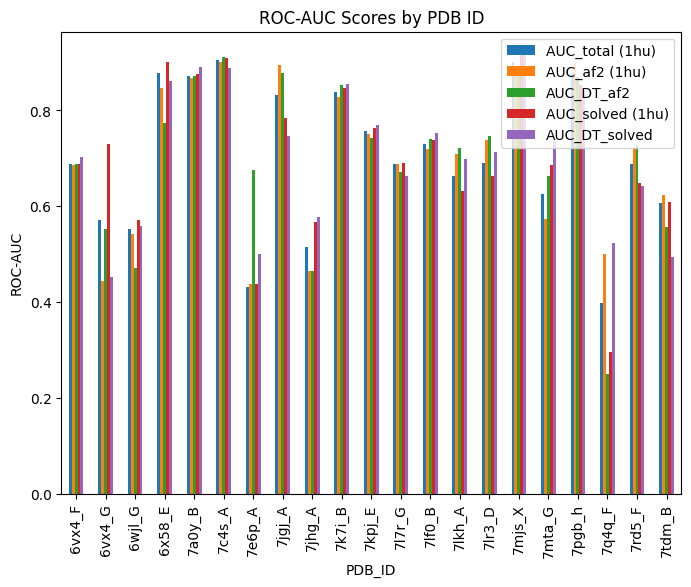

In [35]:
# Plot columns on bar chart
df_results[['PDB_ID', 'AUC_total (1hu)', 'AUC_af2 (1hu)', 'AUC_DT_af2', 'AUC_solved (1hu)', 'AUC_DT_solved']].plot(x='PDB_ID', kind='bar', figsize=(8, 6))

plt.ylabel('ROC-AUC')
plt.title('ROC-AUC Scores by PDB ID')
plt.savefig('AUC_test_1hu.png', format='png', dpi=1200, facecolor='white', bbox_inches='tight')

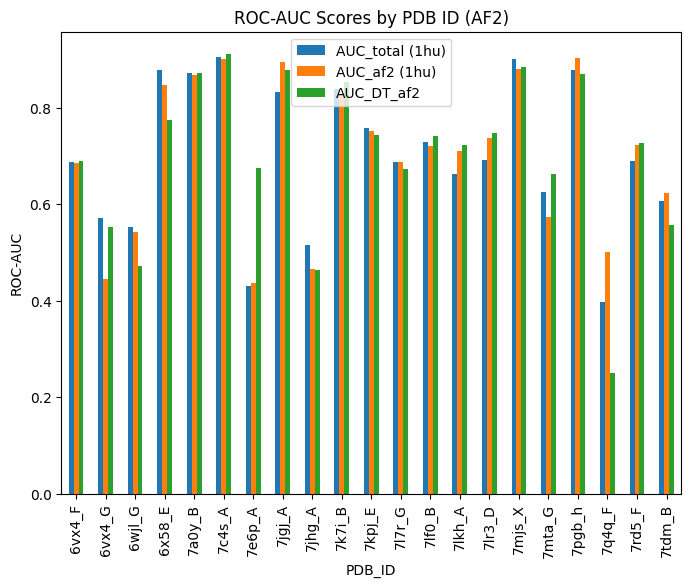

In [36]:
# Plot columns on bar chart
df_results[['PDB_ID', 'AUC_total (1hu)', 'AUC_af2 (1hu)', 'AUC_DT_af2']].plot(x='PDB_ID', kind='bar', figsize=(8, 6))

plt.ylabel('ROC-AUC')
plt.title('ROC-AUC Scores by PDB ID (AF2)')
plt.savefig('AUC_af2_test_1hu.png', format='png', dpi=1200, facecolor='white', bbox_inches='tight')

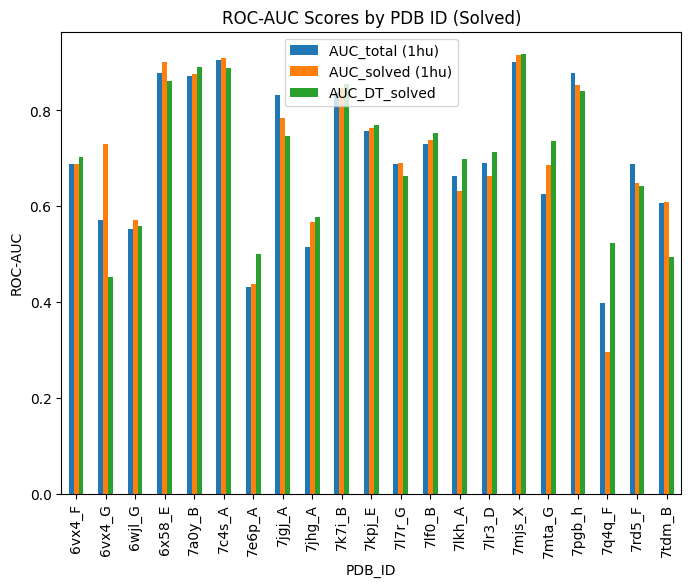

In [37]:
# Plot columns on bar chart
df_results[['PDB_ID', 'AUC_total (1hu)', 'AUC_solved (1hu)', 'AUC_DT_solved']].plot(x='PDB_ID', kind='bar', figsize=(8, 6))

plt.ylabel('ROC-AUC')
plt.title('ROC-AUC Scores by PDB ID (Solved)')
plt.savefig('AUC_solved_test_1hu.png', format='png', dpi=1200, facecolor='white', bbox_inches='tight')

## Training with whole data set (10 hidden unit structure)

In [38]:
# Parameters definition
loss = 'binary_crossentropy'
act = 'relu'
l2_value = 0.01
drop = 0.4
batch_size = 128
class_balancing = False

In [39]:
# Training and validation of the model
model10, history10 = nn10_model(train_data=X_train_sc, y_train=y_train, act_fun=act, loss_fun=loss, alpha=l2_value, 
                                class_weight_fn=class_weight_calculator, drop_rate=drop, 
                                batch = batch_size, balancing = class_balancing)    

# Obtaining probabilities values for whole test, test_PDB, and test_AF2
y_pred_test_prob_10 = model10.predict(X_test_sc)
y_pred_test_PDB_prob_10 = model10.predict(X_test_PDB_sc)
y_pred_test_af2_prob_10 = model10.predict(X_test_af2_sc)

186/186 [==============================] - 0s 1ms/step


In [40]:
# Mean of the y_pred_valid_prob
y_pred_test_prob_10_mean = np.empty(len(y_pred_test_PDB_prob_10))
for i in range(0, len(y_pred_test_PDB_prob_10), 1):
    y_pred_test_prob_10_mean[i] = (y_pred_test_prob_10[i] + y_pred_test_prob_10[len(y_pred_test_PDB_prob_10)+i])/2

In [41]:
# Loop to calculate the AUC for each PDB id (protein)

k = 0
cont = 0
AUC_id_total_10 = np.empty(len(PDB_id))
AUC_id_solved_10 = np.empty(len(PDB_id))
AUC_id_af2_10 = np.empty(len(PDB_id))

for i in PDB_id:
    
    # Predicted values for a protein
    y_pred_id_10 = np.concatenate((y_pred_test_prob_10[cont:(cont+int(PDB_length_dict[i]))], 
                                   y_pred_test_prob_10[(cont+len(y_test_PDB)):(cont+len(y_test_PDB)+int(PDB_length_dict[i]))]))
    y_pred_id_solved_10 = y_pred_test_PDB_prob_10[cont:(cont+int(PDB_length_dict[i]))]
    y_pred_id_af2_10 = y_pred_test_af2_prob_10[cont:(cont+int(PDB_length_dict[i]))]
    
    # Real values for a protein
    y_test_id = np.concatenate((y_test[cont:(cont+int(PDB_length_dict[i]))], 
                               y_test[(cont+len(y_test_PDB)):(cont+len(y_test_PDB)+int(PDB_length_dict[i]))]))
    y_test_id_solved = y_test_PDB[cont:(cont+int(PDB_length_dict[i]))]
    y_test_id_af2 = y_test_af2[cont:(cont+int(PDB_length_dict[i]))]
    
    # AUC value for each protein
    AUC_id_total_10[k] = ROC_AUC(y_test_id, y_pred_id_10)
    AUC_id_solved_10[k] = ROC_AUC(y_test_id_solved, y_pred_id_solved_10)
    AUC_id_af2_10[k] = ROC_AUC(y_test_id_af2, y_pred_id_af2_10)
    
    k += 1
    cont = cont + int(PDB_length_dict[i])

In [42]:
# AUC scores for each type of test set
AUC_id_total_10, AUC_id_solved_10, AUC_id_af2_10

(array([0.62295396, 0.72029148, 0.5868086 , 0.83333333, 0.86550992,
        0.90204122, 0.50625   , 0.75969584, 0.48436778, 0.85554847,
        0.69152228, 0.66559919, 0.71007549, 0.63950413, 0.64448925,
        0.90602908, 0.60528942, 0.85414334, 0.5       , 0.69717445,
        0.62939815]),
 array([0.63695652, 0.71300448, 0.62481709, 0.86400591, 0.8684136 ,
        0.90304183, 0.45      , 0.69345661, 0.53239671, 0.86862245,
        0.69894802, 0.68018018, 0.72926829, 0.63553719, 0.61357527,
        0.93063892, 0.65918164, 0.8387458 , 0.5       , 0.66584767,
        0.64583333]),
 array([0.60396419, 0.80493274, 0.55823822, 0.79379157, 0.86487252,
        0.89943966, 0.525     , 0.8508493 , 0.44283205, 0.84119898,
        0.68966584, 0.6600976 , 0.69436702, 0.66446281, 0.70598118,
        0.87261571, 0.56112774, 0.86506159, 0.5       , 0.72563473,
        0.60578704]))

In [43]:
# Dataframe with the AUC results of each protein (PDB ID)

import warnings
warnings.filterwarnings('ignore')

# Create an empty DataFrame with the required columns
df_results_10 = pd.DataFrame(columns=['PDB_ID', 'Length', 'AUC_total (10hu)', 'AUC_af2 (10hu)', 'AUC_DT_af2', 
                                      'AUC_solved (10hu)', 'AUC_DT_solved'])

cont = 0
for i in range(0, len(stats_test_solved), 1):
    
    # Loading results dataframe and important variables
    sample = stats_test_solved[i]
    pdb_id = sample['pdb'][0][0:6]
    length_pdb = sample['length'][0]
    
    # Calculate the AUC value for each protain according from the DiscoTope model (AF2)
    df_discotope = pd.read_csv('discotope3_testset_benchmark.csv')
    y_pred_af2_discotope = df_discotope.loc[df_discotope['pdb'] == pdb_id, 'DT3_af2']
    y_test_id_af2 = y_test_af2[cont:(cont+int(length_pdb))]
    AUC_af2_discotope = ROC_AUC(y_test_id_af2, y_pred_af2_discotope)
    
    # Calculate the AUC value for each protain according from the DiscoTope model (solved)
    y_pred_solved_discotope = df_discotope.loc[df_discotope['pdb'] == pdb_id, 'DT3_solved']
    y_test_id_solved = y_test_PDB[cont:(cont+int(length_pdb))]
    AUC_solved_discotope = ROC_AUC(y_test_id_solved, y_pred_solved_discotope)
    
    # Create a new row with the specific values
    new_row = pd.DataFrame([[pdb_id, length_pdb, AUC_id_total_10[i], AUC_id_af2_10[i], AUC_af2_discotope, AUC_id_solved_10[i], AUC_solved_discotope]], 
                           columns=['PDB_ID', 'Length', 'AUC_total (10hu)', 'AUC_af2 (10hu)', 'AUC_DT_af2', 'AUC_solved (10hu)', 'AUC_DT_solved'])
    
    # Add the new row to the DataFrame
    df_results_10 = df_results_10.append(new_row, ignore_index=True)
    # Update cont variable
    cont = cont + int(length_pdb)
    
# Save the dataframe to a .csv file in the 'output' folder
df_results_10.to_csv(('output_test/test_comparison_10hu.csv'), index=False)
df_results_10.to_excel(('output_test/test_comparison_10hu.xlsx'), index=False, engine='xlsxwriter')

print('All results stored correctly as .csv and .xlsx files')

All results stored correctly as .csv and .xlsx files


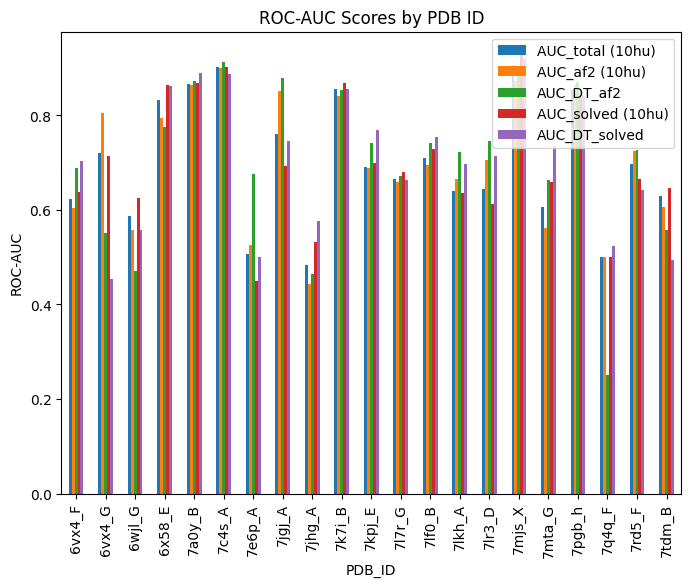

In [44]:
# Plot columns on bar chart
df_results_10[['PDB_ID', 'AUC_total (10hu)', 'AUC_af2 (10hu)', 'AUC_DT_af2', 'AUC_solved (10hu)', 'AUC_DT_solved']].plot(x='PDB_ID', kind='bar', figsize=(8, 6))

plt.ylabel('ROC-AUC')
plt.title('ROC-AUC Scores by PDB ID')
plt.savefig('AUC_test_10hu.png', format='png', dpi=1200, facecolor='white', bbox_inches='tight')

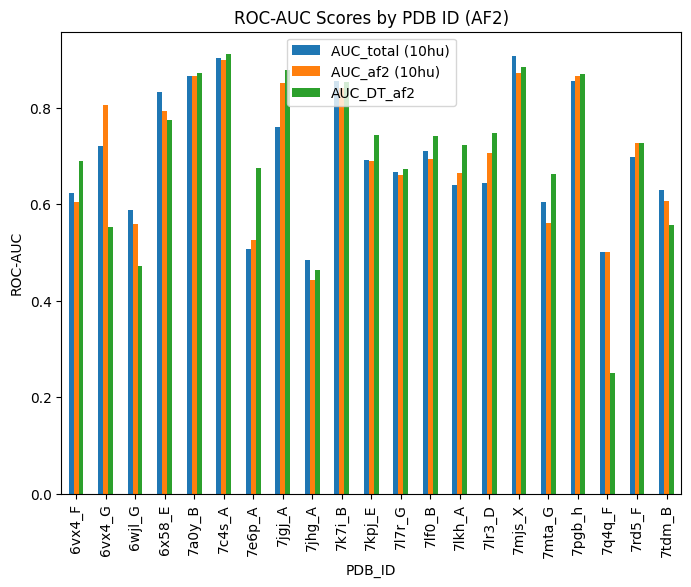

In [45]:
# Plot columns on bar chart
df_results_10[['PDB_ID', 'AUC_total (10hu)', 'AUC_af2 (10hu)', 'AUC_DT_af2']].plot(x='PDB_ID', kind='bar', figsize=(8, 6))

plt.ylabel('ROC-AUC')
plt.title('ROC-AUC Scores by PDB ID (AF2)')
plt.savefig('AUC_af2_test_10hu.png', format='png', dpi=1200, facecolor='white', bbox_inches='tight')

In [46]:
# Check how many AUC values for the network are higher than DT, for all of the AF2 test set

AUC_af2 = df_results_10['AUC_af2 (10hu)'].values
AUC_af2_DT = df_results_10['AUC_DT_af2'].values

count = 0
for i in range(len(AUC_af2)):
    if AUC_af2[i] > AUC_af2_DT[i]:
        count += 1

print("AUC_af2 (network) has bigger values than AUC_af2_DT", count, "times", "out of", str(len(AUC_af2)), "(", str(count/len(AUC_af2)), ")")

AUC_af2 (network) has bigger values than AUC_af2_DT 5 times out of 21 ( 0.23809523809523808 )


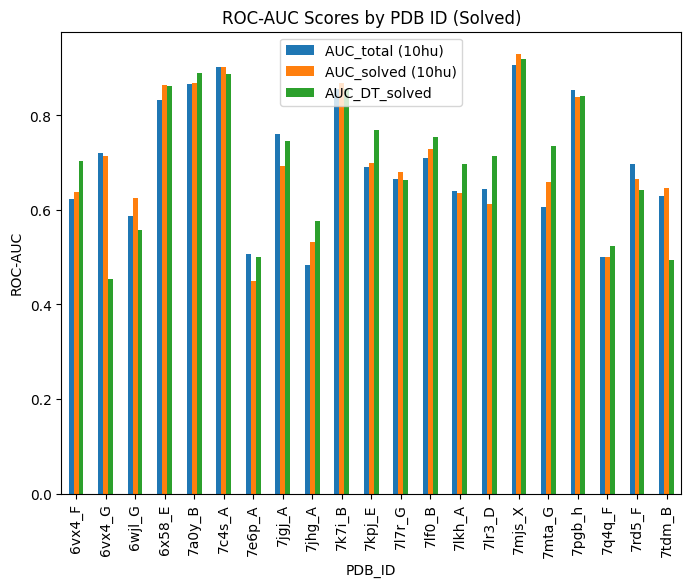

In [47]:
# Plot columns on bar chart
df_results_10[['PDB_ID', 'AUC_total (10hu)', 'AUC_solved (10hu)', 'AUC_DT_solved']].plot(x='PDB_ID', kind='bar', figsize=(8, 6))

plt.ylabel('ROC-AUC')
plt.title('ROC-AUC Scores by PDB ID (Solved)')
plt.savefig('AUC_solved_test_10hu.png', format='png', dpi=1200, facecolor='white', bbox_inches='tight')

In [48]:
# Check how many AUC values for the network are higher than DT, for all of the PDB test set

AUC_solved = df_results_10['AUC_solved (10hu)'].values
AUC_solved_DT = df_results_10['AUC_DT_solved'].values

count = 0
for i in range(len(AUC_solved)):
    if AUC_solved[i] > AUC_solved_DT[i]:
        count += 1

print("AUC_solved (network) has bigger values than AUC_solved_DT", count, "times", "out of", str(len(AUC_solved)), "(", str(count/len(AUC_solved)), ")")

AUC_solved (network) has bigger values than AUC_solved_DT 9 times out of 21 ( 0.42857142857142855 )


## Comparison of 1 hidden unit VS 10 hidden units

In [49]:
# Dataframe with the AUC results of each protein (PDB ID)

import warnings
warnings.filterwarnings('ignore')

# Create an empty DataFrame with the required columns
df_results_mix = pd.DataFrame(columns=['PDB_ID', 'Length', 'AUC_total (1hu)', 'AUC_total (10hu)', 'AUC_af2 (1hu)', 'AUC_af2 (10hu)', 
                                       'AUC_DT_af2', 'AUC_solved (1hu)', 'AUC_solved (10hu)', 'AUC_DT_solved'])

cont = 0
for i in range(0, len(stats_test_solved), 1):
    
    # Loading results dataframe and important variables
    sample = stats_test_solved[i]
    pdb_id = sample['pdb'][0][0:6]
    length_pdb = sample['length'][0]
    
    # Calculate the AUC value for each protain according from the DiscoTope model (AF2)
    df_discotope = pd.read_csv('discotope3_testset_benchmark.csv')
    y_pred_af2_discotope = df_discotope.loc[df_discotope['pdb'] == pdb_id, 'DT3_af2']
    y_test_id_af2 = y_test_af2[cont:(cont+int(length_pdb))]
    AUC_af2_discotope = ROC_AUC(y_test_id_af2, y_pred_af2_discotope)
    
    # Calculate the AUC value for each protain according from the DiscoTope model (solved)
    y_pred_solved_discotope = df_discotope.loc[df_discotope['pdb'] == pdb_id, 'DT3_solved']
    y_test_id_solved = y_test_PDB[cont:(cont+int(length_pdb))]
    AUC_solved_discotope = ROC_AUC(y_test_id_solved, y_pred_solved_discotope)
    
    # Create a new row with the specific values
    new_row = pd.DataFrame([[pdb_id, length_pdb, AUC_id_total[i], AUC_id_total_10[i], AUC_id_af2[i], AUC_id_af2_10[i], AUC_af2_discotope, AUC_id_solved[i], AUC_id_solved_10[i], AUC_solved_discotope]], 
                           columns=['PDB_ID', 'Length', 'AUC_total (1hu)', 'AUC_total (10hu)', 'AUC_af2 (1hu)', 'AUC_af2 (10hu)', 'AUC_DT_af2', 'AUC_solved (1hu)', 'AUC_solved (10hu)', 'AUC_DT_solved'])
    
    # Add the new row to the DataFrame
    df_results_mix = df_results_mix.append(new_row, ignore_index=True)
    # Update cont variable
    cont = cont + int(length_pdb)
    
# Save the dataframe to a .csv file in the 'output' folder
df_results_mix.to_csv(('output_test/test_comparison_mix.csv'), index=False)
df_results_mix.to_excel(('output_test/test_comparison_mix.xlsx'), index=False, engine='xlsxwriter')

print('All results stored correctly as .csv and .xlsx files')

All results stored correctly as .csv and .xlsx files


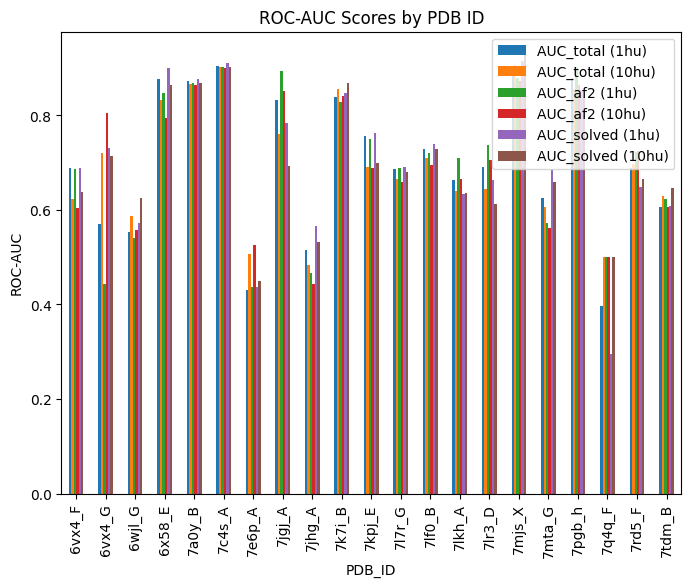

In [50]:
# Plot columns on bar chart
df_results_mix[['PDB_ID', 'AUC_total (1hu)', 'AUC_total (10hu)', 'AUC_af2 (1hu)', 'AUC_af2 (10hu)', 'AUC_solved (1hu)', 'AUC_solved (10hu)']].plot(x='PDB_ID', kind='bar', figsize=(8, 6))

plt.ylabel('ROC-AUC')
plt.title('ROC-AUC Scores by PDB ID')
plt.savefig('AUC_test_1vs10hu.png', format='png', dpi=1200, facecolor='white', bbox_inches='tight')

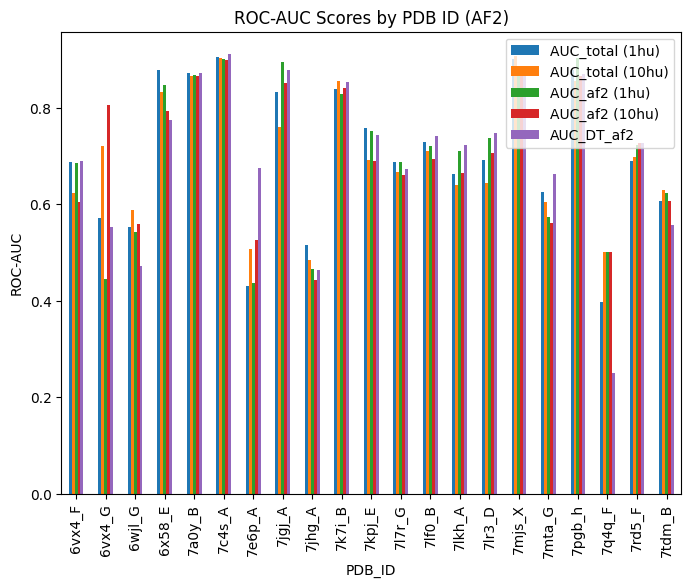

In [51]:
# Plot columns on bar chart
df_results_mix[['PDB_ID', 'AUC_total (1hu)', 'AUC_total (10hu)', 'AUC_af2 (1hu)', 'AUC_af2 (10hu)', 'AUC_DT_af2']].plot(x='PDB_ID', kind='bar', figsize=(8, 6))

plt.ylabel('ROC-AUC')
plt.title('ROC-AUC Scores by PDB ID (AF2)')
plt.savefig('AUC_af2_test_1vs10hu.png', format='png', dpi=1200, facecolor='white', bbox_inches='tight')

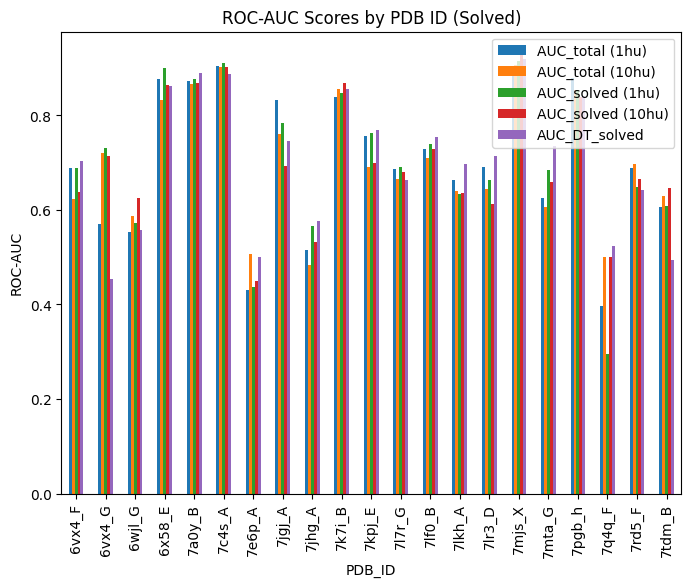

In [52]:
# Plot columns on bar chart
df_results_mix[['PDB_ID', 'AUC_total (1hu)', 'AUC_total (10hu)', 'AUC_solved (1hu)', 'AUC_solved (10hu)', 'AUC_DT_solved']].plot(x='PDB_ID', kind='bar', figsize=(8, 6))

plt.ylabel('ROC-AUC')
plt.title('ROC-AUC Scores by PDB ID (Solved)')
plt.savefig('AUC_solved_test_1vs10hu.png', format='png', dpi=1200, facecolor='white', bbox_inches='tight')

In [53]:
# Check how many AUC values for 1hu are higher than 10hu, for all of the PDB test set

AUC_total_1hu = df_results_mix['AUC_total (1hu)'].values
AUC_total_10hu = df_results_mix['AUC_total (10hu)'].values

count = 0
for i in range(len(AUC_total_1hu)):
    if AUC_total_1hu[i] > AUC_total_10hu[i]:
        count += 1

print("AUC_total_1hu has bigger values than AUC_total_10hu:", count, "times", "out of", str(len(AUC_total_1hu)), "(", str(count/len(AUC_total_1hu)), ")")

AUC_total_1hu has bigger values than AUC_total_10hu: 13 times out of 21 ( 0.6190476190476191 )


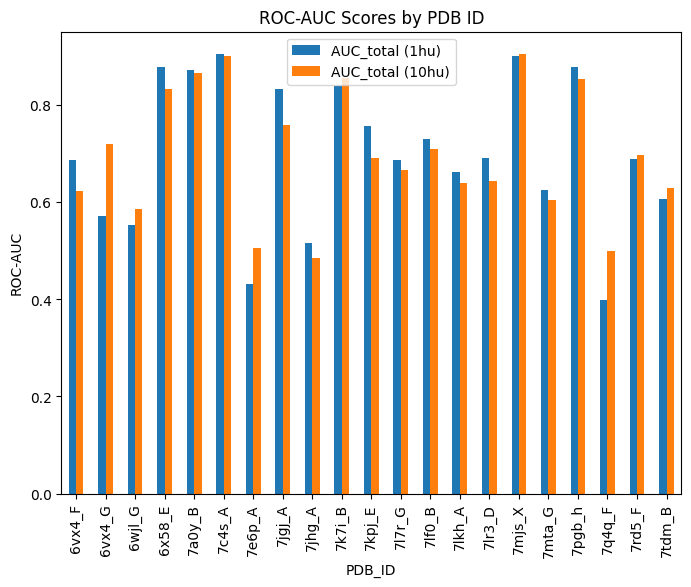

In [54]:
# Plot columns on bar chart
df_results_mix[['PDB_ID', 'AUC_total (1hu)', 'AUC_total (10hu)']].plot(x='PDB_ID', kind='bar', figsize=(8, 6))

plt.ylabel('ROC-AUC')
plt.title('ROC-AUC Scores by PDB ID')
plt.savefig('AUC_total_test_1vs10hu.png', format='png', dpi=1200, facecolor='white', bbox_inches='tight')